In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [4]:
df = pd.read_csv('Data/dataset_futbol_limpio_1.0.csv', delimiter=',', index_col='Player')
df

,Nation,Pos,Squad,Comp,Age,MP,Starts,Min,90s,Goals,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
Player,,,,,,,,,,,,,,,,,,,,,
Brenden Aaronson,USA,MF,Leeds United,Premier League,22,20,19,1596,17.7,1,...,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,22.2
Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,22,22,1980,22.0,0,...,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,64.0
Himad Abdelli,FRA,MF,Angers,Ligue 1,23,14,8,770,8.6,0,...,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,47.1
Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,20,20,1799,20.0,1,...,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,50.0
Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,15,15,1165,12.9,0,...,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Szymon ?urkowski,POL,MF,Fiorentina,Serie A,25,2,0,32,0.4,0,...,0.00,2.50,0.00,0.0,0.0,0.00,5.00,2.50,2.50,50.0
Szymon ?urkowski,POL,MF,Spezia,Serie A,25,1,0,8,0.1,0,...,0.00,0.00,0.00,0.0,0.0,0.00,30.00,0.00,0.00,0.0
Martin Ødegaard,NOR,MF,Arsenal,Premier League,24,20,20,1684,18.7,8,...,0.05,2.51,0.70,0.0,0.0,0.00,5.19,0.48,0.70,40.9


Ahora, de manera similar a lo que hicimos en la sección de comparación de jugadores, vamos a realizar un clustering de los jugadores basándonos en sus estadísticas. Para ello, vamos a utilizar el algoritmo de K-means, hemos dividido a los jugadores en 4 grupos, y hemos seleccionado detenidamente ls caracteristicas mejor valorada de cada posición.

Ahora vamos a proceder a hacer un modelo que sea capaz de predecir al mejor reemplazo para un jugador en caso de que este se lesionase o abandonase el clun. Para ello, vamos a realizar un modelo de clustering basado en las estadísticas de los jugadores, que hemos desigando previamente. Utilizaremos el algoritmo de K-means, para ello, primero estandarizaremos las características y despues aplicaremos el modelo.

In [5]:
# Definimos las características por posición
#Estas características han sido seleccionada a raíz conocimientos deportivos y estadísticos.
features_por_posicion = {
    'GK': ['AerWon', 'AerWon%', 'PasTotCmp', 'PasTotAtt', 'PasLonCmp', 'PasLonAtt', 'PasLonCmp%', 'CrsPA', 'Tkl', 'Recov', 'Off'],
    'DF': ['Tkl', 'TklWon', 'TklDef3rd', 'Blocks', 'BlkSh', 'Int', 'Clr', 'Tkl+Int', 'PasLonCmp', 'PasLonAtt', 'PasLonCmp%', 'PasProg', 'Pas3rd', 'Recov'],
    'MF': ['PasTotCmp', 'PasTotAtt', 'PasTotCmp%', 'PasTotPrgDist', 'PasAss', 'Pas3rd', 'PPA', 'PasProg', 'SCA', 'ScaPassLive', 'GCA', 'CarTotDist', 'CarPrgDist', 'CPA', 'Rec'],
    'FW': ['Goals', 'Shots', 'SoT', 'G/Sh', 'G/SoT', 'ShoDist', 'Assists', 'PasAss', 'PasProg', 'SCA', 'ScaDrib', 'GCA', 'TouAttPen', 'PKwon', 'Off']
}

#

In [12]:


def scout_similar_players(jugador, n=10):
    posicion = df.loc[jugador, 'Pos'] #Obtenemos la posición del jugador
    features = features_por_posicion[posicion] #Seleccionamos las características segun la posicion
    
    df_posicion = df[df['Pos'] == posicion] #Filtramos a los jugadores de la misma pos
    
    # Vamos a normalizar las caracteristicas, este un proceso común en este tipo de modelos, ya que la normalizacion mejora los resultados.
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_posicion[features]), columns=features, index=df_posicion.index)
    
    #Vamos a utlizar la distnacia Euclidea como métrica de cercanía
    jugador_vector = df_scaled.loc[jugador].values
    distancias = np.linalg.norm(df_scaled.values - jugador_vector, axis=1)
    
    # Crearemos un nuevo Dataframe con los jugadores y sus distancias
    df_distancias = pd.DataFrame({'jugador': df_scaled.index, 'distancia': distancias})
    
    # Ordenamos por distancia y seleccionamos los n más cercanos (excluyendo al jugador mismo)
    df_similares = df_distancias[df_distancias['jugador'] != jugador].sort_values('distancia').head(n)
    
    # Calculamos el porcentaje de similitud (100% - porcentaje de distancia)
    max_distancia = df_distancias['distancia'].max()
    df_similares['similitud'] = (1 - df_similares['distancia'] / max_distancia) * 100
    
    return df_similares[['jugador', 'similitud']]


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Función que calcula los jugadores similares y crea un gráfico
def scout_similar_players(jugador, n=10):
    posicion = df.loc[jugador, 'Pos'] #Obtenemos la posición del jugador
    features = features_por_posicion[posicion] #Seleccionamos las características segun la posicion
    
    df_posicion = df[df['Pos'] == posicion] #Filtramos a los jugadores de la misma pos
    
    # Vamos a normalizar las caracteristicas, este un proceso común en este tipo de modelos, ya que la normalizacion mejora los resultados.
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_posicion[features]), columns=features, index=df_posicion.index)
    
    #Vamos a utlizar la distnacia Euclidea como métrica de cercanía
    jugador_vector = df_scaled.loc[jugador].values
    distancias = np.linalg.norm(df_scaled.values - jugador_vector, axis=1)
    
    # Crearemos un nuevo Dataframe con los jugadores y sus distancias
    df_distancias = pd.DataFrame({'jugador': df_scaled.index, 'distancia': distancias})
    
    # Ordenamos por distancia y seleccionamos los n más cercanos (excluyendo al jugador mismo)
    df_similares = df_distancias[df_distancias['jugador'] != jugador].sort_values('distancia').head(n)
    
    # Calculamos el porcentaje de similitud (100% - porcentaje de distancia)
    max_distancia = df_distancias['distancia'].max()
    df_similares['similitud'] = (1 - df_similares['distancia'] / max_distancia) * 100
    
    # Graficamos los resultados
    plt.figure(figsize=(10, 6))
    plt.barh(df_similares['jugador'], df_similares['similitud'], color='skyblue')
    plt.xlabel('Similarity (%)')
    plt.title(f'Top {n} similar players to {jugador}')
    plt.gca().invert_yaxis()  # Invertimos el eje para mostrar el más similar en la parte superior
    plt.show()

    return df_similares[['jugador', 'similitud']]



-Ejemplos de uso:

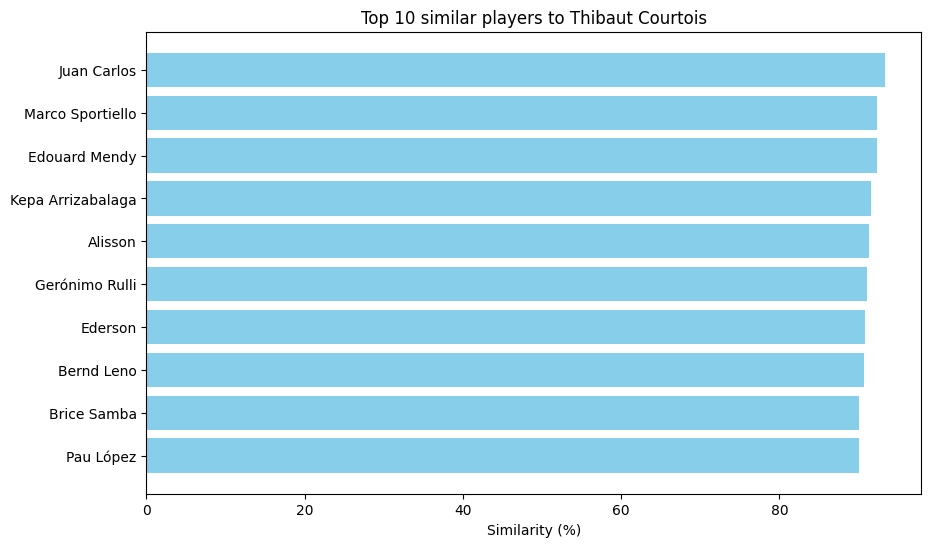

Jugadores similares a Thibaut Courtois:
Juan Carlos: 93.30%
Marco Sportiello: 92.33%
Edouard Mendy: 92.32%
Kepa Arrizabalaga: 91.58%
Alisson: 91.31%
Gerónimo Rulli: 91.07%
Ederson: 90.81%
Bernd Leno: 90.73%
Brice Samba: 90.04%
Pau López: 90.02%


In [18]:
jugador_ejemplo = "Thibaut Courtois"
similares = scout_similar_players(jugador_ejemplo)
print(f"Jugadores similares a {jugador_ejemplo}:")
for _, row in similares.iterrows():
    print(f"{row['jugador']}: {row['similitud']:.2f}%")

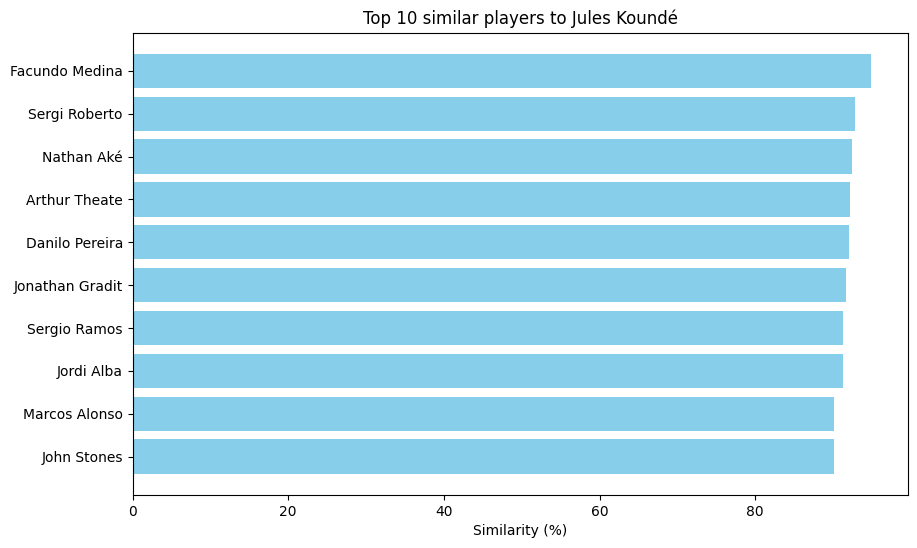

Jugadores similares a Jules Koundé:
Facundo Medina: 94.84%
Sergi Roberto: 92.76%
Nathan Aké: 92.43%
Arthur Theate: 92.23%
Danilo Pereira: 92.01%
Jonathan Gradit: 91.71%
Sergio Ramos: 91.34%
Jordi Alba: 91.23%
Marcos Alonso: 90.14%
John Stones: 90.11%


In [19]:
jugador_ejemplo = "Jules Koundé"
similares = scout_similar_players(jugador_ejemplo)
print(f"Jugadores similares a {jugador_ejemplo}:")
for _, row in similares.iterrows():
    print(f"{row['jugador']}: {row['similitud']:.2f}%")

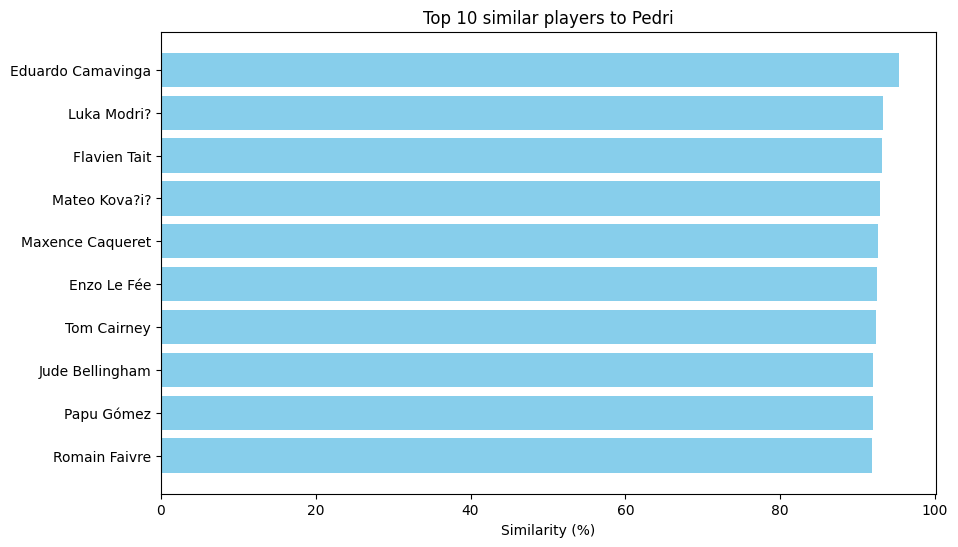

Jugadores similares a Pedri:
Eduardo Camavinga: 95.34%
Luka Modri?: 93.26%
Flavien Tait: 93.12%
Mateo Kova?i?: 92.88%
Maxence Caqueret: 92.67%
Enzo Le Fée: 92.46%
Tom Cairney: 92.38%
Jude Bellingham: 91.98%
Papu Gómez: 91.96%
Romain Faivre: 91.88%


In [20]:
jugador_ejemplo = "Pedri"
similares = scout_similar_players(jugador_ejemplo)
print(f"Jugadores similares a {jugador_ejemplo}:")
for _, row in similares.iterrows():
    print(f"{row['jugador']}: {row['similitud']:.2f}%")

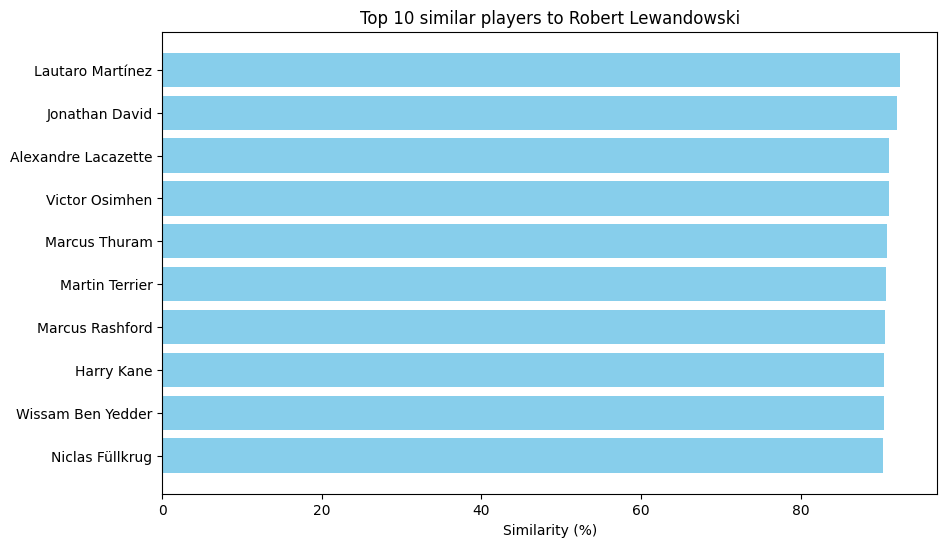

Jugadores similares a Robert Lewandowski:
Lautaro Martínez: 92.50%
Jonathan David: 92.14%
Alexandre Lacazette: 91.13%
Victor Osimhen: 91.09%
Marcus Thuram: 90.86%
Martin Terrier: 90.73%
Marcus Rashford: 90.64%
Harry Kane: 90.46%
Wissam Ben Yedder: 90.42%
Niclas Füllkrug: 90.36%


In [21]:
jugador_ejemplo = "Robert Lewandowski"
similares = scout_similar_players(jugador_ejemplo)
print(f"Jugadores similares a {jugador_ejemplo}:")
for _, row in similares.iterrows():
    print(f"{row['jugador']}: {row['similitud']:.2f}%")